In [1]:
!wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619330926&Signature=TE%2BGGQsC%2FbpTt3lqGkCFHaiLT6wQTPgL60%2B9LX4%2BZBS8%2FCNOsENnM7aE0zhY3UKoXYtdQE7obSmWZjZolkRhrG0c%2Bl0o8Q62hdrlSUOlY5jP08ZbW5i9MQMv0lFEjuIxCCSNiriBPx7puqUABCLsCLMzJh3qAntyCuCecFr3BQRxSp7b6a4ptaRluECUjKSElQqFVwr38HMAloivuffuBEly40%2FoRuFDncGnww4YQfJ%2BVtm5246osVPy6ZZKydOiTD32aR3cs8FZWZ798NIXYsYvOr4eVXu%2BpTHhCMW6%2BeSmSU3SCayVGp0jcdkQ%2Ff7e%2FSReqltZ8Eq2Go4%2BOEaSxA%3D%3D&response-content-disposition=attachment%3B+filename%3Dultrasound-nerve-segmentation.zip' --output-document 'ultrasound-nerve-segmentation.zip'
!pip install q keras==2.4.1
!pip install segmentation_models
!pip install tensorflow_io
!unzip '/content/ultrasound-nerve-segmentation.zip'

In [2]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:
img=pd.read_csv('/content/drive/MyDrive/dup_rem.csv')
df=pd.read_csv('/content/train_masks.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

In [6]:
pos_df=new_df[new_df.mask_pres==1]

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(pos_df.image_path, pos_df.mask_path, test_size=0.2, random_state=42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
im_height=128
im_width=128

In [9]:
def atrous_block(input):
  '''Implement DAC block as given in paper'''
  q1=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr0',dilation_rate=1,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr1',dilation_rate=2,activation='relu')(input)
  q2=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr2',dilation_rate=1,activation='relu')(q2)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr3',dilation_rate=1,activation='relu')(input)
  q3=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr4',dilation_rate=2,activation='relu')(q3)
  q3=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr5',dilation_rate=1,activation='relu')(q3)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr6',dilation_rate=1,activation='relu')(input)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr7',dilation_rate=2,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(3,3),padding='same',strides=1,name='atr8',dilation_rate=4,activation='relu')(q4)
  q4=Conv2D(filters=512,kernel_size=(1,1),padding='same',strides=1,name='atr9',dilation_rate=1,activation='relu')(q4)
  atr_out=concatenate([q1,q2,q3,q4],axis=-1)
  print(atr_out.shape)
  return atr_out


In [10]:
def rmp_block(input):
  '''Implement RMP block as given in paper'''
  X1=MaxPooling2D((2,2),strides=(2,2))(input)
  X1=Conv2DTranspose(512,(2,2),padding='same',activation='relu',strides=(2,2))(X1)
  X2=MaxPooling2D((3,3),strides=(2,2),padding='same')(input)
  X2=Conv2DTranspose(512,(3,3),padding='same',activation='relu',strides=(2,2))(X2)
  X3=MaxPooling2D((5,5),strides=(2,2),padding='same')(input)
  X3=Conv2DTranspose(512,(5,5),padding='same',activation='relu',strides=(2,2))(X3)
  X4=MaxPooling2D((6,6),strides=(2,2),padding='same')(input)
  X4=Conv2DTranspose(512,(6,6),padding='same',activation='relu',strides=(2,2))(X4)
  concat=concatenate([X1,X2,X3,X4],axis=-1)
  return concat


In [11]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    #conv layer followed by batchnormalization
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

In [12]:
def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual Unet + Dense Atrous convolution + Rmp block"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)

    conv4 = convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling2D((2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)

    conv5 = convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    #atrous conv or dillated conv is when filter has holes in it.
    conv5=atrous_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    conv5=rmp_block(conv5)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    ups6 = Conv2DTranspose(filters * 8, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

    ups7 = Conv2DTranspose(filters * 4, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv2DTranspose(filters * 2, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    ups9 = Conv2DTranspose(filters * 1, (3, 3), strides = (2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
def tfdata_generator(images, maskname, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,maskname):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        
        mask=tf.io.read_file(maskname)
        mask=tfio.experimental.image.decode_tiff(mask)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [im_height, im_width],method='nearest')
        return image,mask
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        labels = tf.image.flip_left_right(labels)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        labels = tf.image.flip_up_down(image)
        
        return image,labels    
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),tf.image.rot90(labels,val)
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,maskname))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    # augmentations = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.4:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.5:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [14]:
tf.keras.backend.clear_session()
tr_image_generator = tfdata_generator(X_train,y_train, is_training=True, batch_size=64)
val_image_generator = tfdata_generator(X_valid,y_valid, is_training=False, batch_size=64)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [15]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False),
    tensorboard_callback]

/usr/local/lib/python3.7/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [21]:
# im_height=128
# im_width=128
# input_img = Input((im_height, im_width,4), name='img')
# model = resunet_opt(input_img, filters=16, dropout=0.4, batchnorm=True)
model.compile(optimizer=Adam(lr=1e-5), loss=focal_loss, metrics=[iou_score])

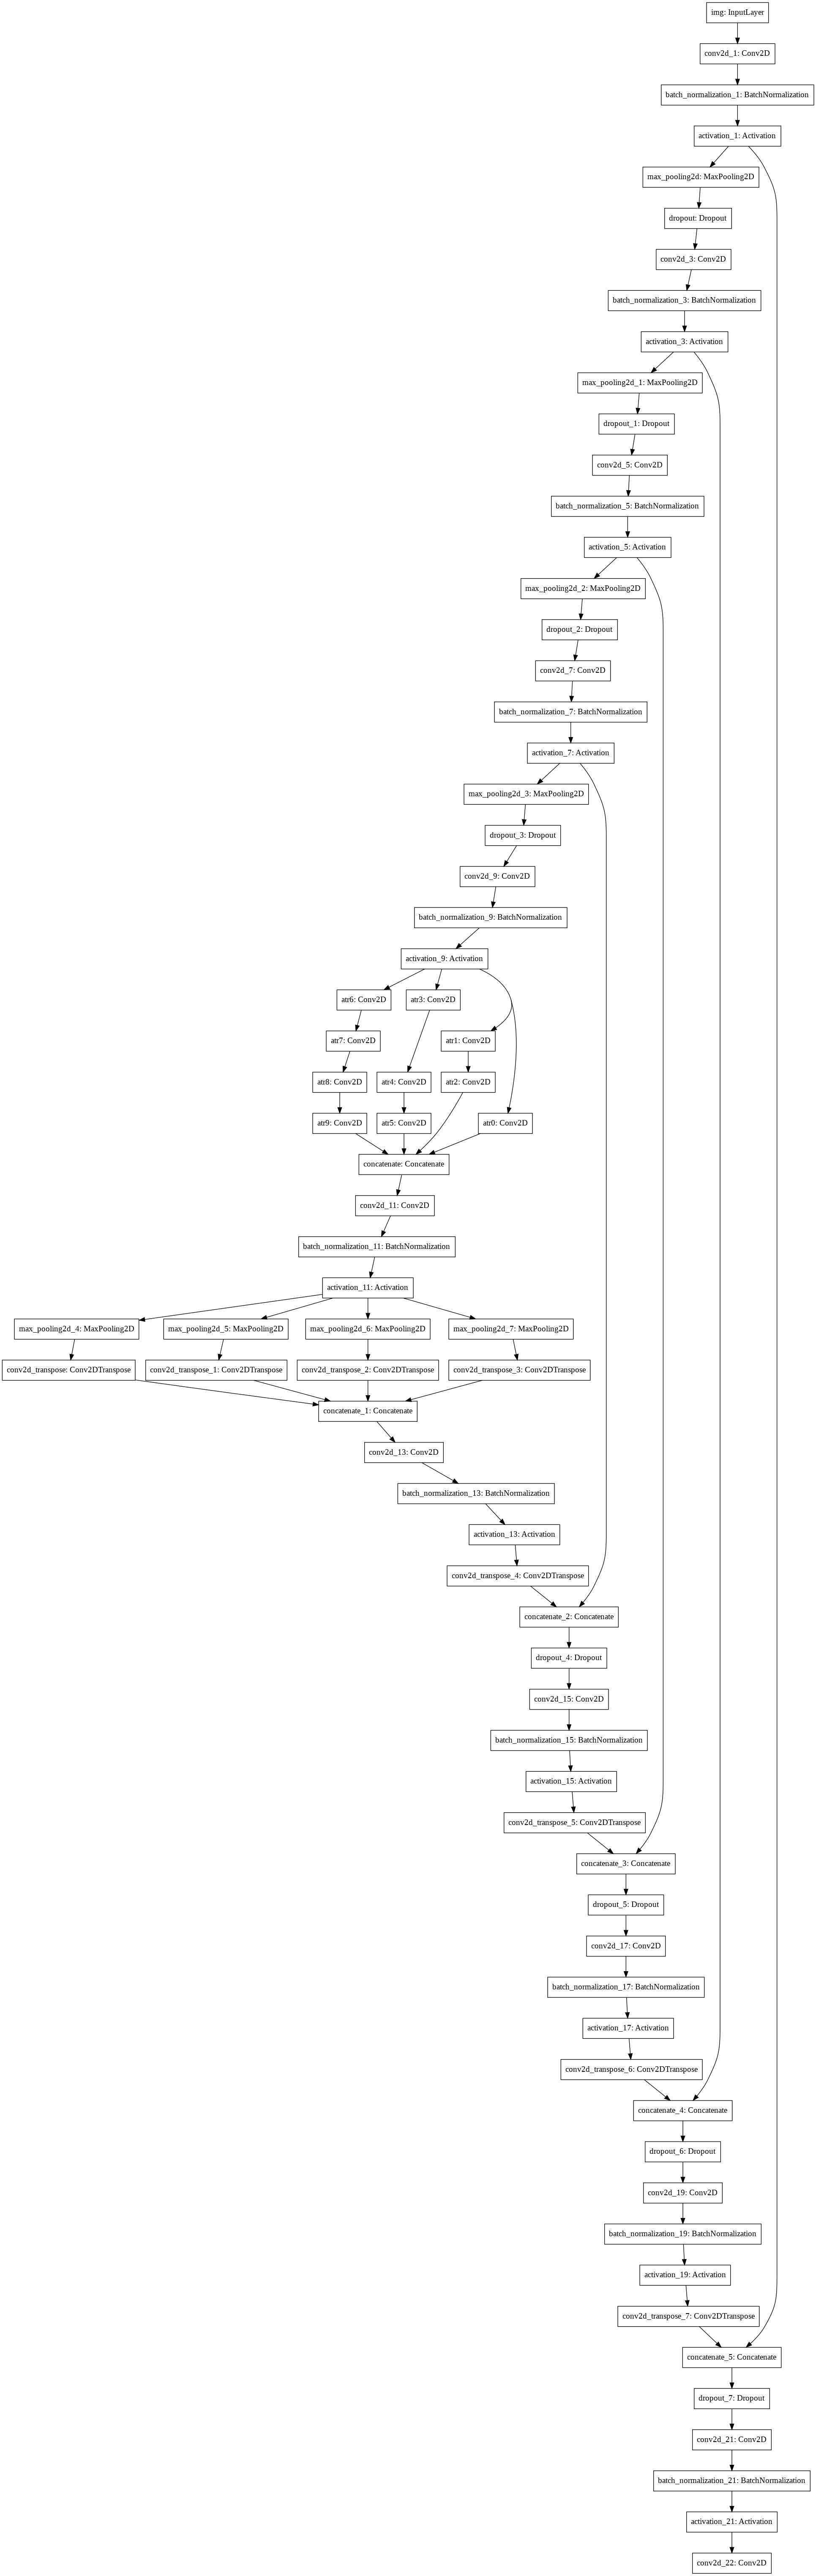

In [ ]:
plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [26]:
result=model.fit(tr_image_generator,steps_per_epoch=64,epochs=45,validation_data=val_image_generator,validation_steps=64,callbacks=callbacks,initial_epoch=35)

Epoch 36/45
64/64 [==============================] - 67s 1s/step - loss: 0.2333 - iou_score: 0.7139 - val_loss: 0.2397 - val_iou_score: 0.7028

Epoch 00036: val_loss did not improve from 0.23898
Epoch 37/45
64/64 [==============================] - 64s 1s/step - loss: 0.2358 - iou_score: 0.7114 - val_loss: 0.2389 - val_iou_score: 0.7039

Epoch 00037: val_loss improved from 0.23898 to 0.23891, saving model to best_model.h5
Epoch 38/45
64/64 [==============================] - 64s 1s/step - loss: 0.2362 - iou_score: 0.7109 - val_loss: 0.2399 - val_iou_score: 0.7028

Epoch 00038: val_loss did not improve from 0.23891
Epoch 39/45
64/64 [==============================] - 64s 1s/step - loss: 0.2351 - iou_score: 0.7120 - val_loss: 0.2398 - val_iou_score: 0.7028

Epoch 00039: val_loss did not improve from 0.23891
Epoch 40/45
64/64 [==============================] - 64s 1s/step - loss: 0.2352 - iou_score: 0.7119 - val_loss: 0.2390 - val_iou_score: 0.7038

Epoch 00040: val_loss did not improve fro

In [ ]:
model.load_weights('best_model.h5')